In [53]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
from tensorflow import keras
import numpy as np
import pathlib
import os
import cv2
import PIL
import PIL.Image
import time
import datetime
import matplotlib.pyplot as plt
print(tf.__version__)
import tensorboard
tensorboard.__version__


2.7.0


'2.7.0'

In [54]:
data_dir = "/media/waqar/Data/PMS/exp-new-class/training"
data_dir = pathlib.Path(data_dir)
print("Training-Directory: ",data_dir)
total_class = 3

Training-Directory:  /media/waqar/Data/PMS/exp-new-class/training


In [55]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1404


In [56]:
batch_size = 16
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 1404 files belonging to 3 classes.
Using 1124 files for training.
Found 1404 files belonging to 3 classes.
Using 280 files for validation.


In [57]:
class_names = np.array(train_ds.class_names)
print(class_names)
class_names_val = np.array(val_ds.class_names)
print(class_names_val)

['1' '2' '3']
['1' '2' '3']


In [58]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [59]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomFlip('vertical'),
  tf.keras.layers.RandomRotation(1),
  tf.keras.layers.RandomRotation(2),
  tf.keras.layers.RandomZoom(.5),
  tf.keras.layers.RandomContrast(0.1, 0.2),
])


In [60]:
#train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
#val_ds = val_ds.map(lambda x, y: (data_augmentation(x), y))

In [61]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [62]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = inception_v3 

In [63]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)



In [92]:
image_batch, label_batch = next(iter(train_ds))
print(image_batch.shape, label_batch.shape)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(16, 224, 224, 3) (16,)
(16, 2048)


In [100]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

inputs = keras.Input(shape=(None, None, 3))
x = data_augmentation(inputs)
outputs = model(x)
model = keras.Model(inputs, outputs)
model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_7 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 sequential_9 (Sequential)   (None, None, None, 3)     0         
                                                                 
 sequential_11 (Sequen

In [101]:
predictions = model(image_batch)
predictions.shape

TensorShape([16, 3])

In [102]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.


In [103]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
71/71 [==============================] - 13s 143ms/step - loss: 1.1396 - accuracy: 0.4173 - val_loss: 1.0305 - val_accuracy: 0.5107
Epoch 2/10
71/71 [==============================] - 9s 133ms/step - loss: 1.0253 - accuracy: 0.4920 - val_loss: 0.9118 - val_accuracy: 0.5964
Epoch 3/10
71/71 [==============================] - 9s 131ms/step - loss: 0.8977 - accuracy: 0.5765 - val_loss: 0.8316 - val_accuracy: 0.6071
Epoch 4/10
71/71 [==============================] - 9s 133ms/step - loss: 0.8072 - accuracy: 0.6584 - val_loss: 0.7764 - val_accuracy: 0.6429
Epoch 5/10
71/71 [==============================] - 9s 133ms/step - loss: 0.7613 - accuracy: 0.6806 - val_loss: 0.7320 - val_accuracy: 0.6750
Epoch 6/10
71/71 [==============================] - 9s 133ms/step - loss: 0.7310 - accuracy: 0.7028 - val_loss: 0.6991 - val_accuracy: 0.7250
Epoch 7/10
71/71 [==============================] - 10s 135ms/step - loss: 0.7171 - accuracy: 0.6966 - val_loss: 0.6693 - val_accuracy: 0.7393
Epoc

In [ ]:
%tensorboard --logdir logs/fit

In [96]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
print(predicted_id)
print(class_names)
predicted_label_batch = class_names[predicted_id.numpy()]
print(predicted_label_batch)

tf.Tensor([2 2 1 1 1 1 2 0 2 2 2 1 1 2 0 1], shape=(16,), dtype=int64)
['1' '2' '3']
['3' '3' '2' '2' '2' '2' '3' '1' '3' '3' '3' '2' '2' '3' '1' '2']


2021-12-15 16:40:11.713222: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at strided_slice_op.cc:108 : INVALID_ARGUMENT: slice index 16 of dimension 0 out of bounds.


InvalidArgumentError: slice index 16 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

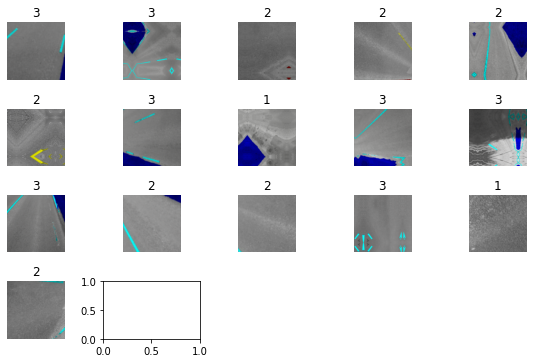

In [98]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

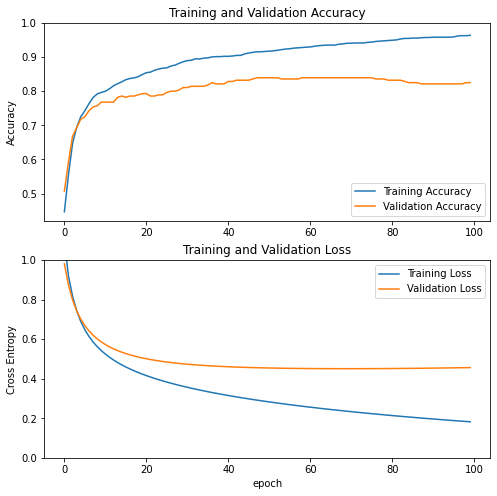

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [82]:
t = time.time()

export_path = "pms_model/model_{}".format(int(t))
!mkdir -p pms_model
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: pms_model/model_1639585580/assets


INFO:tensorflow:Assets written to: pms_model/model_1639585580/assets


'pms_model/model_1639585580'

In [83]:
export_path = 'pms_model/model_1639585580'
reloaded = tf.keras.models.load_model(export_path)
reloaded.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_6 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [76]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

IndexError: too many indices for array: array is 1-dimensional, but 16 were indexed

NameError: name 'reloaded_predicted_label_batch' is not defined

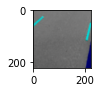

In [77]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [86]:
#Change the variables as per your need
#reloaded = model
test_data_dir = pathlib.Path('/media/waqar/Data/PMS/exp-new-class/test')
print(test_data_dir)
img_height = 224
img_width = 224
batch_size = 1
class_number = 3

test_dataset = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

loss, accuracy = reloaded.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

/media/waqar/Data/PMS/exp-new-class/test
Found 179 files belonging to 3 classes.
179/179 [==============================] - 3s 16ms/step - loss: 0.9814 - accuracy: 0.6872
Test accuracy : 0.6871508359909058
Test loss : 0.9813876748085022


In [ ]:
y_true = []
y_pred = []
count1 = 0
count2 = 0
count3 = 0
countF = 0
for image, label in test_dataset:
    #prediction_batch = reloaded(image)
    predictions = reloaded.predict(image)
    y_true = (label.numpy())
    score = tf.nn.softmax(predictions[0])
    y2_pred = tf.math.argmax(score)

    #if(tf.math.argmax(prediction_batch, axis=1).numpy()==0):
    if(y2_pred==0):
        if(label.numpy()==0):
            count1 = count1 + 1
        else:
            countF = countF + 1
    #elif (tf.math.argmax(prediction_batch, axis=1).numpy()==1):
    elif(y2_pred==1):
        if(label.numpy()==1):
            count2 = count2 + 1
        else:
            countF = countF + 1
          
    #elif (tf.math.argmax(prediction_batch, axis=1).numpy()==2):
    elif(y2_pred==2):
        if(label.numpy()==2):
            count3 = count3 + 1
        else: 
            countF = countF + 1
            
print("count for each class {}: ",count1,count2,count3, countF)

In [88]:
result_test_data_dir = pathlib.Path('/media/waqar/Data/PMS/exp-new-class/test')
output_test_dir = pathlib.Path('/media/waqar/Data/PMS/exp-new-class/output_test-new')
try:
    os.makedirs(output_test_dir, exist_ok=True)
    print("Directory created")
except OSError as e:
    print("Directory already exists")
count = 0
countf = 0
countF = 0
countT = 0
root, class_n, files = next(os.walk(result_test_data_dir))
print(class_n)
for c in class_n:
    new_root = os.path.join(output_test_dir, c)
    try:
        os.mkdir(new_root)
    except OSError as e:
        print("Directory already exists")
    for dirs in os.walk(os.path.join(root, c)):
        for files in dirs:
            for filename in files:
                if(filename.endswith(".jpg")):
                    path = os.path.join(root, c, filename)
                    #img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
                    orig = cv2.imread(path)
                    img = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (img_height, img_width))
                    img_array = tf.keras.utils.img_to_array(img)
                    img_array = tf.expand_dims(img_array, 0) # Create a batch
                    img_array = normalization_layer(img_array)
                    predictions = reloaded.predict(img_array)
                    score = tf.nn.softmax(predictions[0])
                    y_pred = tf.math.argmax(score)
                    y_pred = int(y_pred)
                    if (int(class_names[np.argmax(score)])==int(c)):
                        count=count+1
                    else:
                        countf=countf+1
                    new_filename = filename.split(".")[0]+ filename.split(".")[1] + "_" + "P_" + str(y_pred+1) + ".jpg"
                    new_path = os.path.join(new_root, new_filename)
                    cv2.imwrite(new_path, orig)
                    #print(new_filename )
    countT = countT + count
    countF = countF + countf
    print('class: ',c, 'Total files: ',len(files), 'Total TP of class: ', count, 'Total FP of class: ',countf,'Total TP: ',countT,'Total FN: ',countF, 'Total Files: ', countT+countF)
    count = 0
    countf = 0
print('Total classes: ',c,'Total TP: ', countT, 'Total FP: ',countF)


Directory created
['1', '2', '3']
Directory already exists
class:  1 Total files:  42 Total TP of class:  9 Total FP of class:  33 Total TP:  9 Total FN:  33 Total Files:  42
Directory already exists
class:  2 Total files:  19 Total TP of class:  0 Total FP of class:  19 Total TP:  9 Total FN:  52 Total Files:  61
Directory already exists
class:  3 Total files:  118 Total TP of class:  112 Total FP of class:  6 Total TP:  121 Total FN:  58 Total Files:  179
Total classes:  3 Total TP:  121 Total FP:  58
